In [1]:
#############
## Imports ##
#############

import pickle
import pandas as pd
import numpy as np
import bnlearn as bn
from test_model import test_model

######################
## Boilerplate Code ##
######################

def load_data():
    """Load train and validation datasets from CSV files."""
    # Implement code to load CSV files into DataFrames
    # Example: train_data = pd.read_csv("train_data.csv")
    train_data = pd.read_csv("train_data.csv")
    val_data = pd.read_csv("validation_data.csv")
    print("Data loaded successfully.")
    return train_data, val_data

In [2]:
def make_network(df):
    """Define and fit the initial Bayesian Network."""
    # Code to define the DAG, create and fit Bayesian Network, and return the model
    DAG_edges = [
        ('Start_Stop_ID', 'End_Stop_ID'),
        ('Start_Stop_ID', 'Distance'),
        ('Start_Stop_ID', 'Zones_Crossed'),
        ('Start_Stop_ID', 'Route_Type'),
        ('Start_Stop_ID', 'Fare_Category'),
        ('End_Stop_ID', 'Distance'),
        ('End_Stop_ID', 'Zones_Crossed'),
        ('End_Stop_ID', 'Route_Type'),
        ('End_Stop_ID', 'Fare_Category'),
        ('Distance', 'Zones_Crossed'),
        ('Distance', 'Route_Type'),
        ('Distance', 'Fare_Category'),
        ('Zones_Crossed', 'Route_Type'),
        ('Zones_Crossed', 'Fare_Category'),
        ('Route_Type', 'Fare_Category')
    ]
    
    model = bn.make_DAG(DAG_edges)
    
    model = bn.parameter_learning.fit(model, df)
    print("Initial Bayesian Network created and fitted successfully.")
    
    bn.plot(model, params_static={"layout": "spring", "title": "Initial Bayesian Network"})
    
    return model

In [3]:
def make_pruned_network(df):
    """Define and fit a pruned Bayesian Network."""
    # Code to create a pruned network, fit it, and return the pruned model
    DAG_edges = [
        ('Start_Stop_ID', 'Distance'), 
        ('Start_Stop_ID', 'Zones_Crossed'),
        ('End_Stop_ID', 'Distance'), 
        ('End_Stop_ID', 'Zones_Crossed'), 
        ('Distance', 'Fare_Category'), 
        ('Zones_Crossed', 'Fare_Category'), 
        ('Route_Type', 'Fare_Category')
    ]
    
    model = bn.make_DAG(DAG_edges)
    
    model = bn.parameter_learning.fit(model, df)
    
    initial_score = bn.structure_scores(model, df)
    print(f"Initial model structure score (BIC): {initial_score['bic']}")
    
    best_score = initial_score['bic']
    best_model = model

    for edge in DAG_edges:
        pruned_edges = [e for e in DAG_edges if e != edge]
        
        pruned_model = bn.make_DAG(pruned_edges)
        pruned_model = bn.parameter_learning.fit(pruned_model, df)
        
        pruned_score = bn.structure_scores(pruned_model, df)
        print(f"Score after pruning {edge}: {pruned_score['bic']}")

        if pruned_score['bic'] > best_score:
            best_score = pruned_score['bic']
            best_model = pruned_model
            print(f"Improved model found by removing {edge} with score {best_score}")
    
    print("Pruned Bayesian Network created and fitted successfully.")
    
    bn.plot(best_model, params_static={"layout": "spring", "title": "Pruned Bayesian Network"})
    
    return best_model

In [4]:
def make_optimized_network(df):
    """Perform structure optimization and fit the optimized Bayesian Network."""
    # Code to optimize the structure, fit it, and return the optimized model
    hc_result = bn.structure_learning.fit(df, methodtype='hc', scoretype='bic')
    
    optimized_dag = bn.make_DAG(hc_result['model_edges'])

    optimized_model = bn.parameter_learning.fit(optimized_dag, df)

    bn.plot(optimized_model, params_static={"layout": "spring", "title": "Optimized Bayesian Network (HC Search)"})
    
    print("Optimized network created successfully.")
    
    return optimized_model

In [5]:
def save_model(fname, model):
    """Save the model to a file using pickle."""
    with open(fname, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model successfully saved to {fname}.")

def evaluate(model_name, val_df):
    """Load and evaluate the specified model."""
    with open(f"{model_name}.pkl", 'rb') as f:
        model = pickle.load(f)
        correct_predictions, total_cases, accuracy = test_model(model, val_df)
        print(f"Total Test Cases: {total_cases}")
        print(f"Total Correct Predictions: {correct_predictions} out of {total_cases}")
        print(f"Model accuracy on filtered test cases: {accuracy:.2f}%")

Data loaded successfully.
[bnlearn] >bayes DAG created.
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Start_Stop_ID:
+----------------------+------------+
| Start_Stop_ID(111)   | 0.0109479  |
+----------------------+------------+
| Start_Stop_ID(215)   | 0.00829734 |
+----------------------+------------+
| Start_Stop_ID(505)   | 0.0092612  |
+----------------------+------------+
| Start_Stop_ID(572)   | 0.00371903 |
+----------------------+------------+
| Start_Stop_ID(634)   | 0.00974312 |
+----------------------+------------+
| Start_Stop_ID(668)   | 0.00709252 |
+----------------------+------------+
| Start_Stop_ID(706)   | 0.0287793  |
+----------------------+------------+
| Start_Stop_ID(751)   | 0.00661059 |
+----------------------+------------+
| Start_Stop_ID(770)   | 0.0420323  |
+----------------------+------------+
| Start_Stop_ID(872)   | 0.0145624  |
+----------------------+------------+
| Start_Stop_ID(904)   | 0.00444192 |
+--------

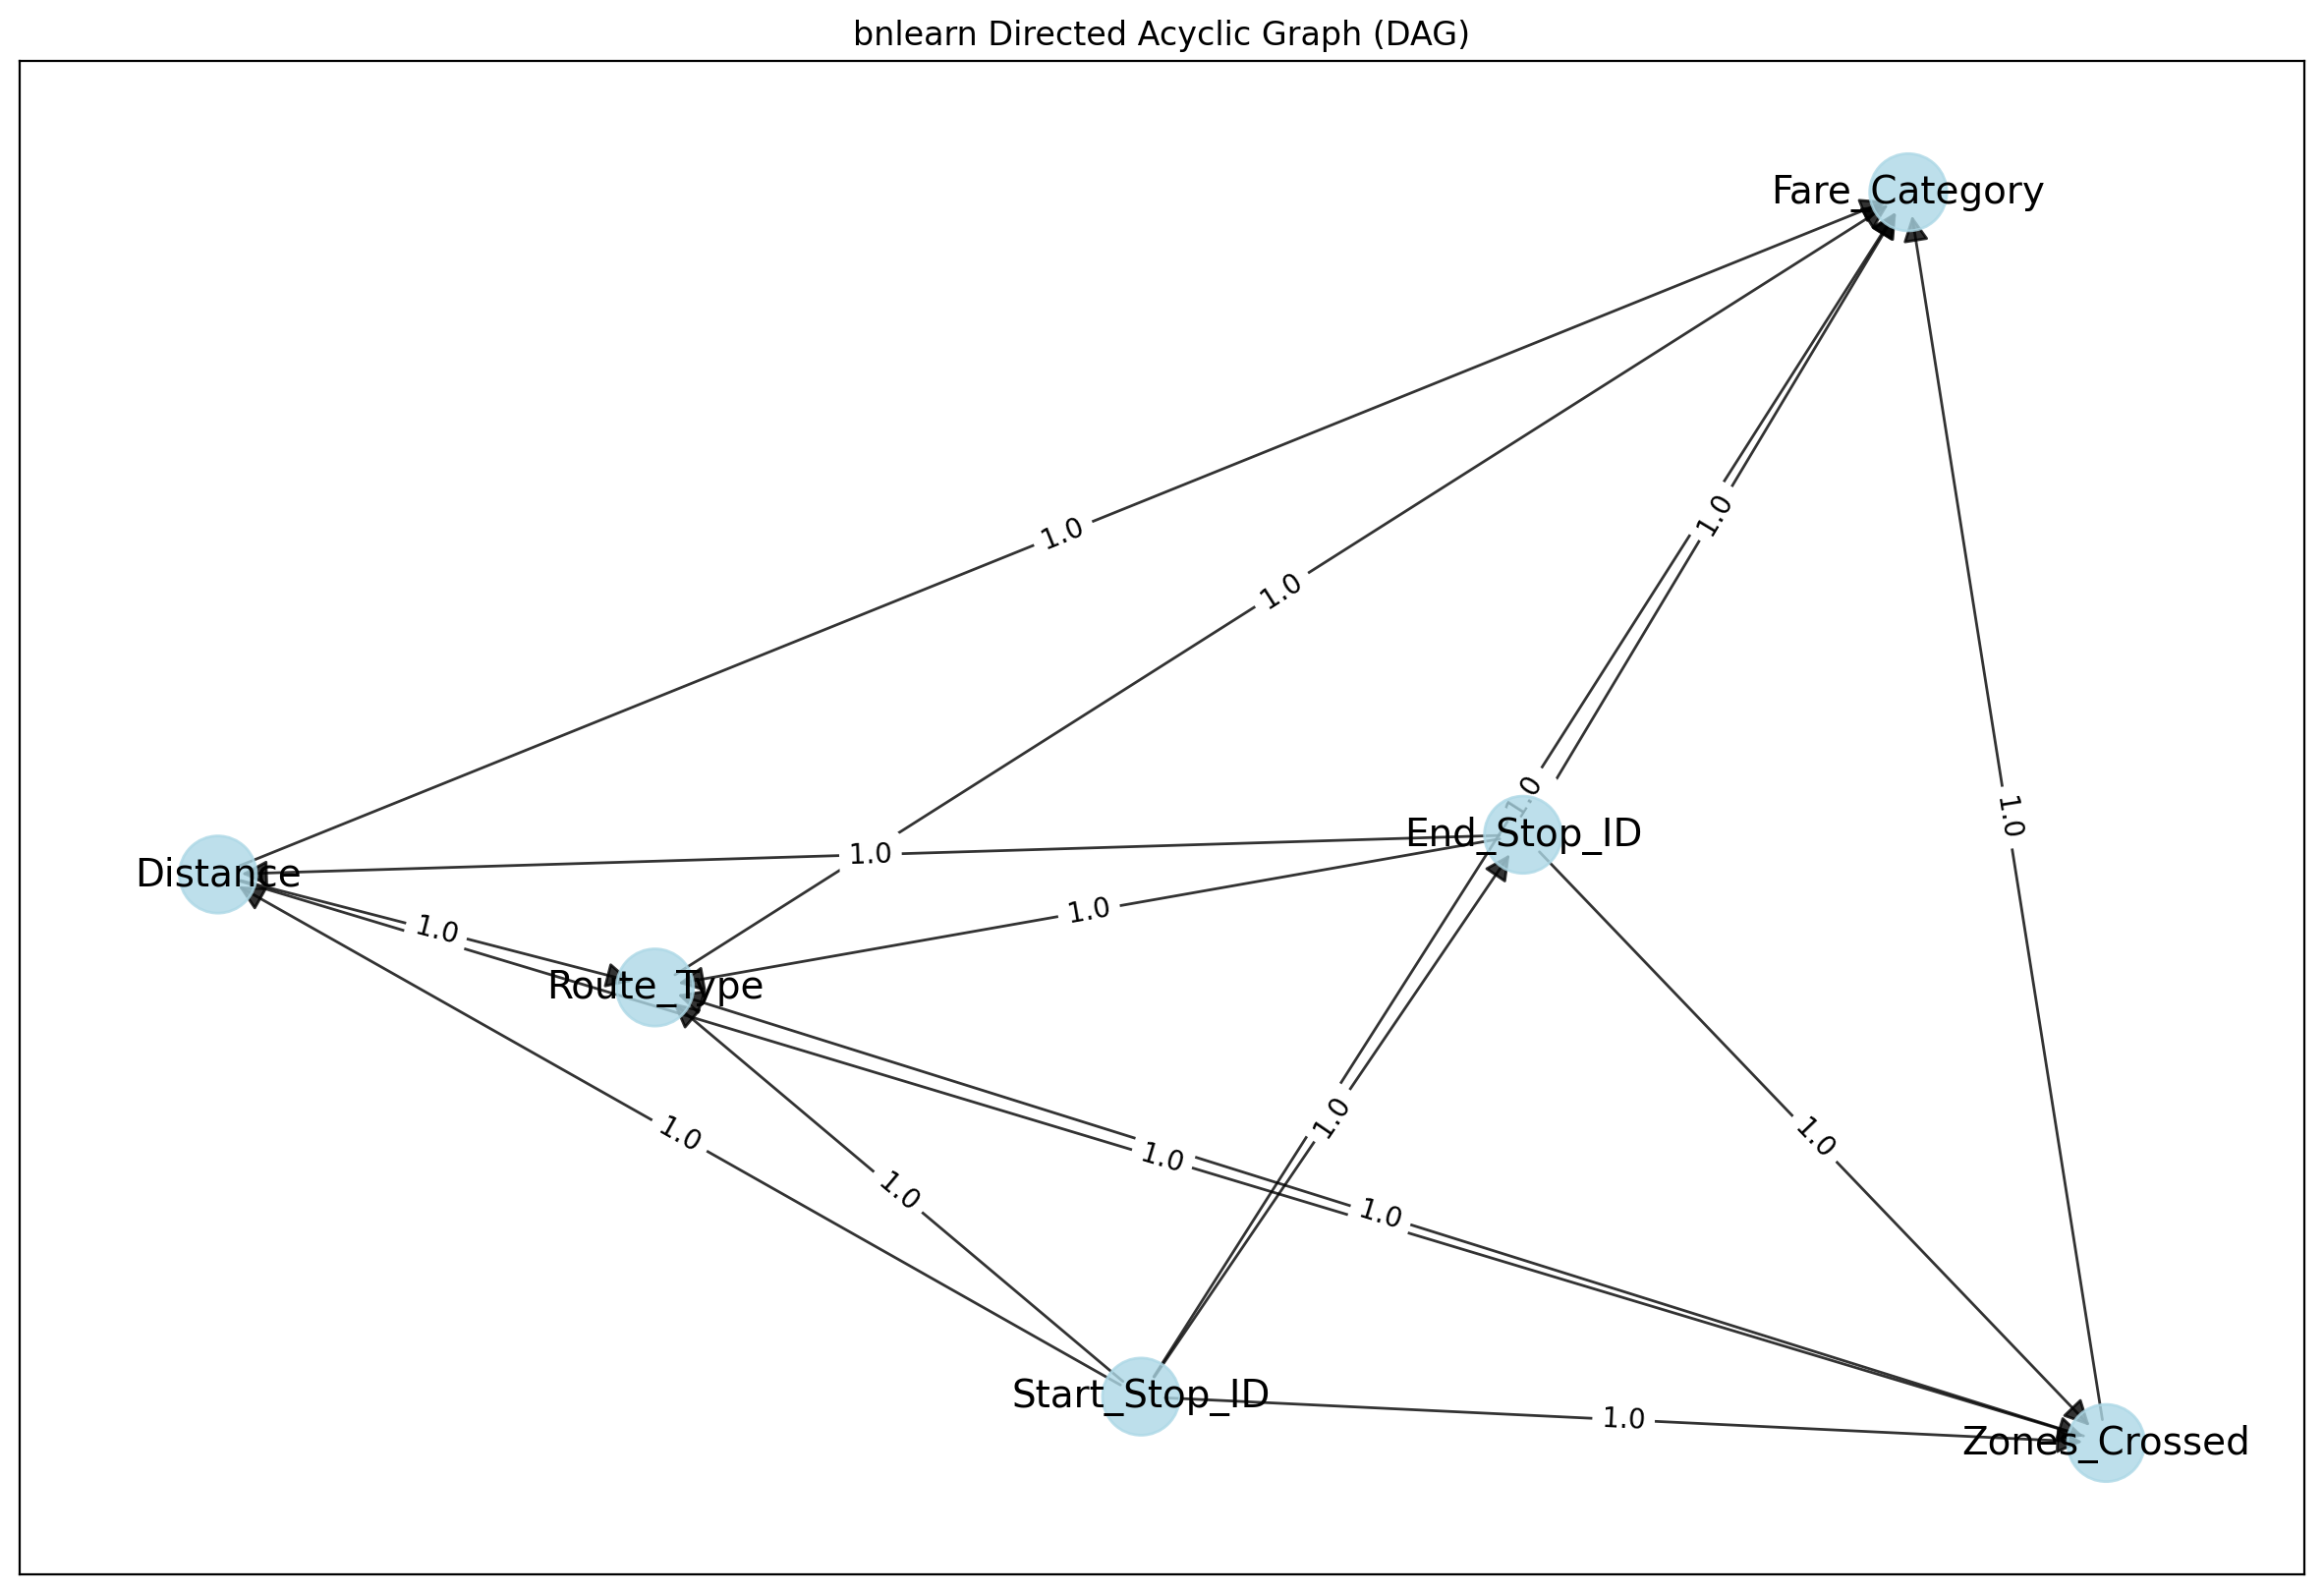

Model successfully saved to base_model.pkl.
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+-------------+
|    | Fare_Category   |           p |
+====+=================+=============+
|  0 | High            | 0.999988    |
+----+-----------------+-------------+
|  1 | Low             | 6.24653e-06 |
+----+-----------------+-------------+
|  2 | Medium          | 6.24653e-06 |
+----+-----------------+-------------+
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+-------------+
|    | Fare_Category   |           p |
+====+=================+=============+
|  0 | High            | 1.01048e-06 |
+----+-----------------+-------------+
|  1 | Low             | 1.01048e-06 |
+----+-----------------+-------------+
|  2 | Medium          | 0.999998    |
+----+---------------

In [6]:
############
## Driver ##
############

def main():
    # Load data
    train_df, val_df = load_data()

    # Create and save base model
    base_model = make_network(train_df.copy())
    save_model("base_model.pkl", base_model)

    # # Create and save pruned model
    # pruned_network = make_pruned_network(train_df.copy())
    # save_model("pruned_model.pkl", pruned_network)

    # # Create and save optimized model
    # optimized_network = make_optimized_network(train_df.copy())
    # save_model("optimized_model.pkl", optimized_network)

    # Evaluate all models on the validation set
    evaluate("base_model", val_df)
    # evaluate("pruned_model", val_df)
    # evaluate("optimized_model", val_df)

    print("[+] Done")

if __name__ == "__main__":
    main()

Data loaded successfully.
[bnlearn] >bayes DAG created.
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Start_Stop_ID:
+----------------------+------------+
| Start_Stop_ID(111)   | 0.0109479  |
+----------------------+------------+
| Start_Stop_ID(215)   | 0.00829734 |
+----------------------+------------+
| Start_Stop_ID(505)   | 0.0092612  |
+----------------------+------------+
| Start_Stop_ID(572)   | 0.00371903 |
+----------------------+------------+
| Start_Stop_ID(634)   | 0.00974312 |
+----------------------+------------+
| Start_Stop_ID(668)   | 0.00709252 |
+----------------------+------------+
| Start_Stop_ID(706)   | 0.0287793  |
+----------------------+------------+
| Start_Stop_ID(751)   | 0.00661059 |
+----------------------+------------+
| Start_Stop_ID(770)   | 0.0420323  |
+----------------------+------------+
| Start_Stop_ID(872)   | 0.0145624  |
+----------------------+------------+
| Start_Stop_ID(904)   | 0.00444192 |
+--------

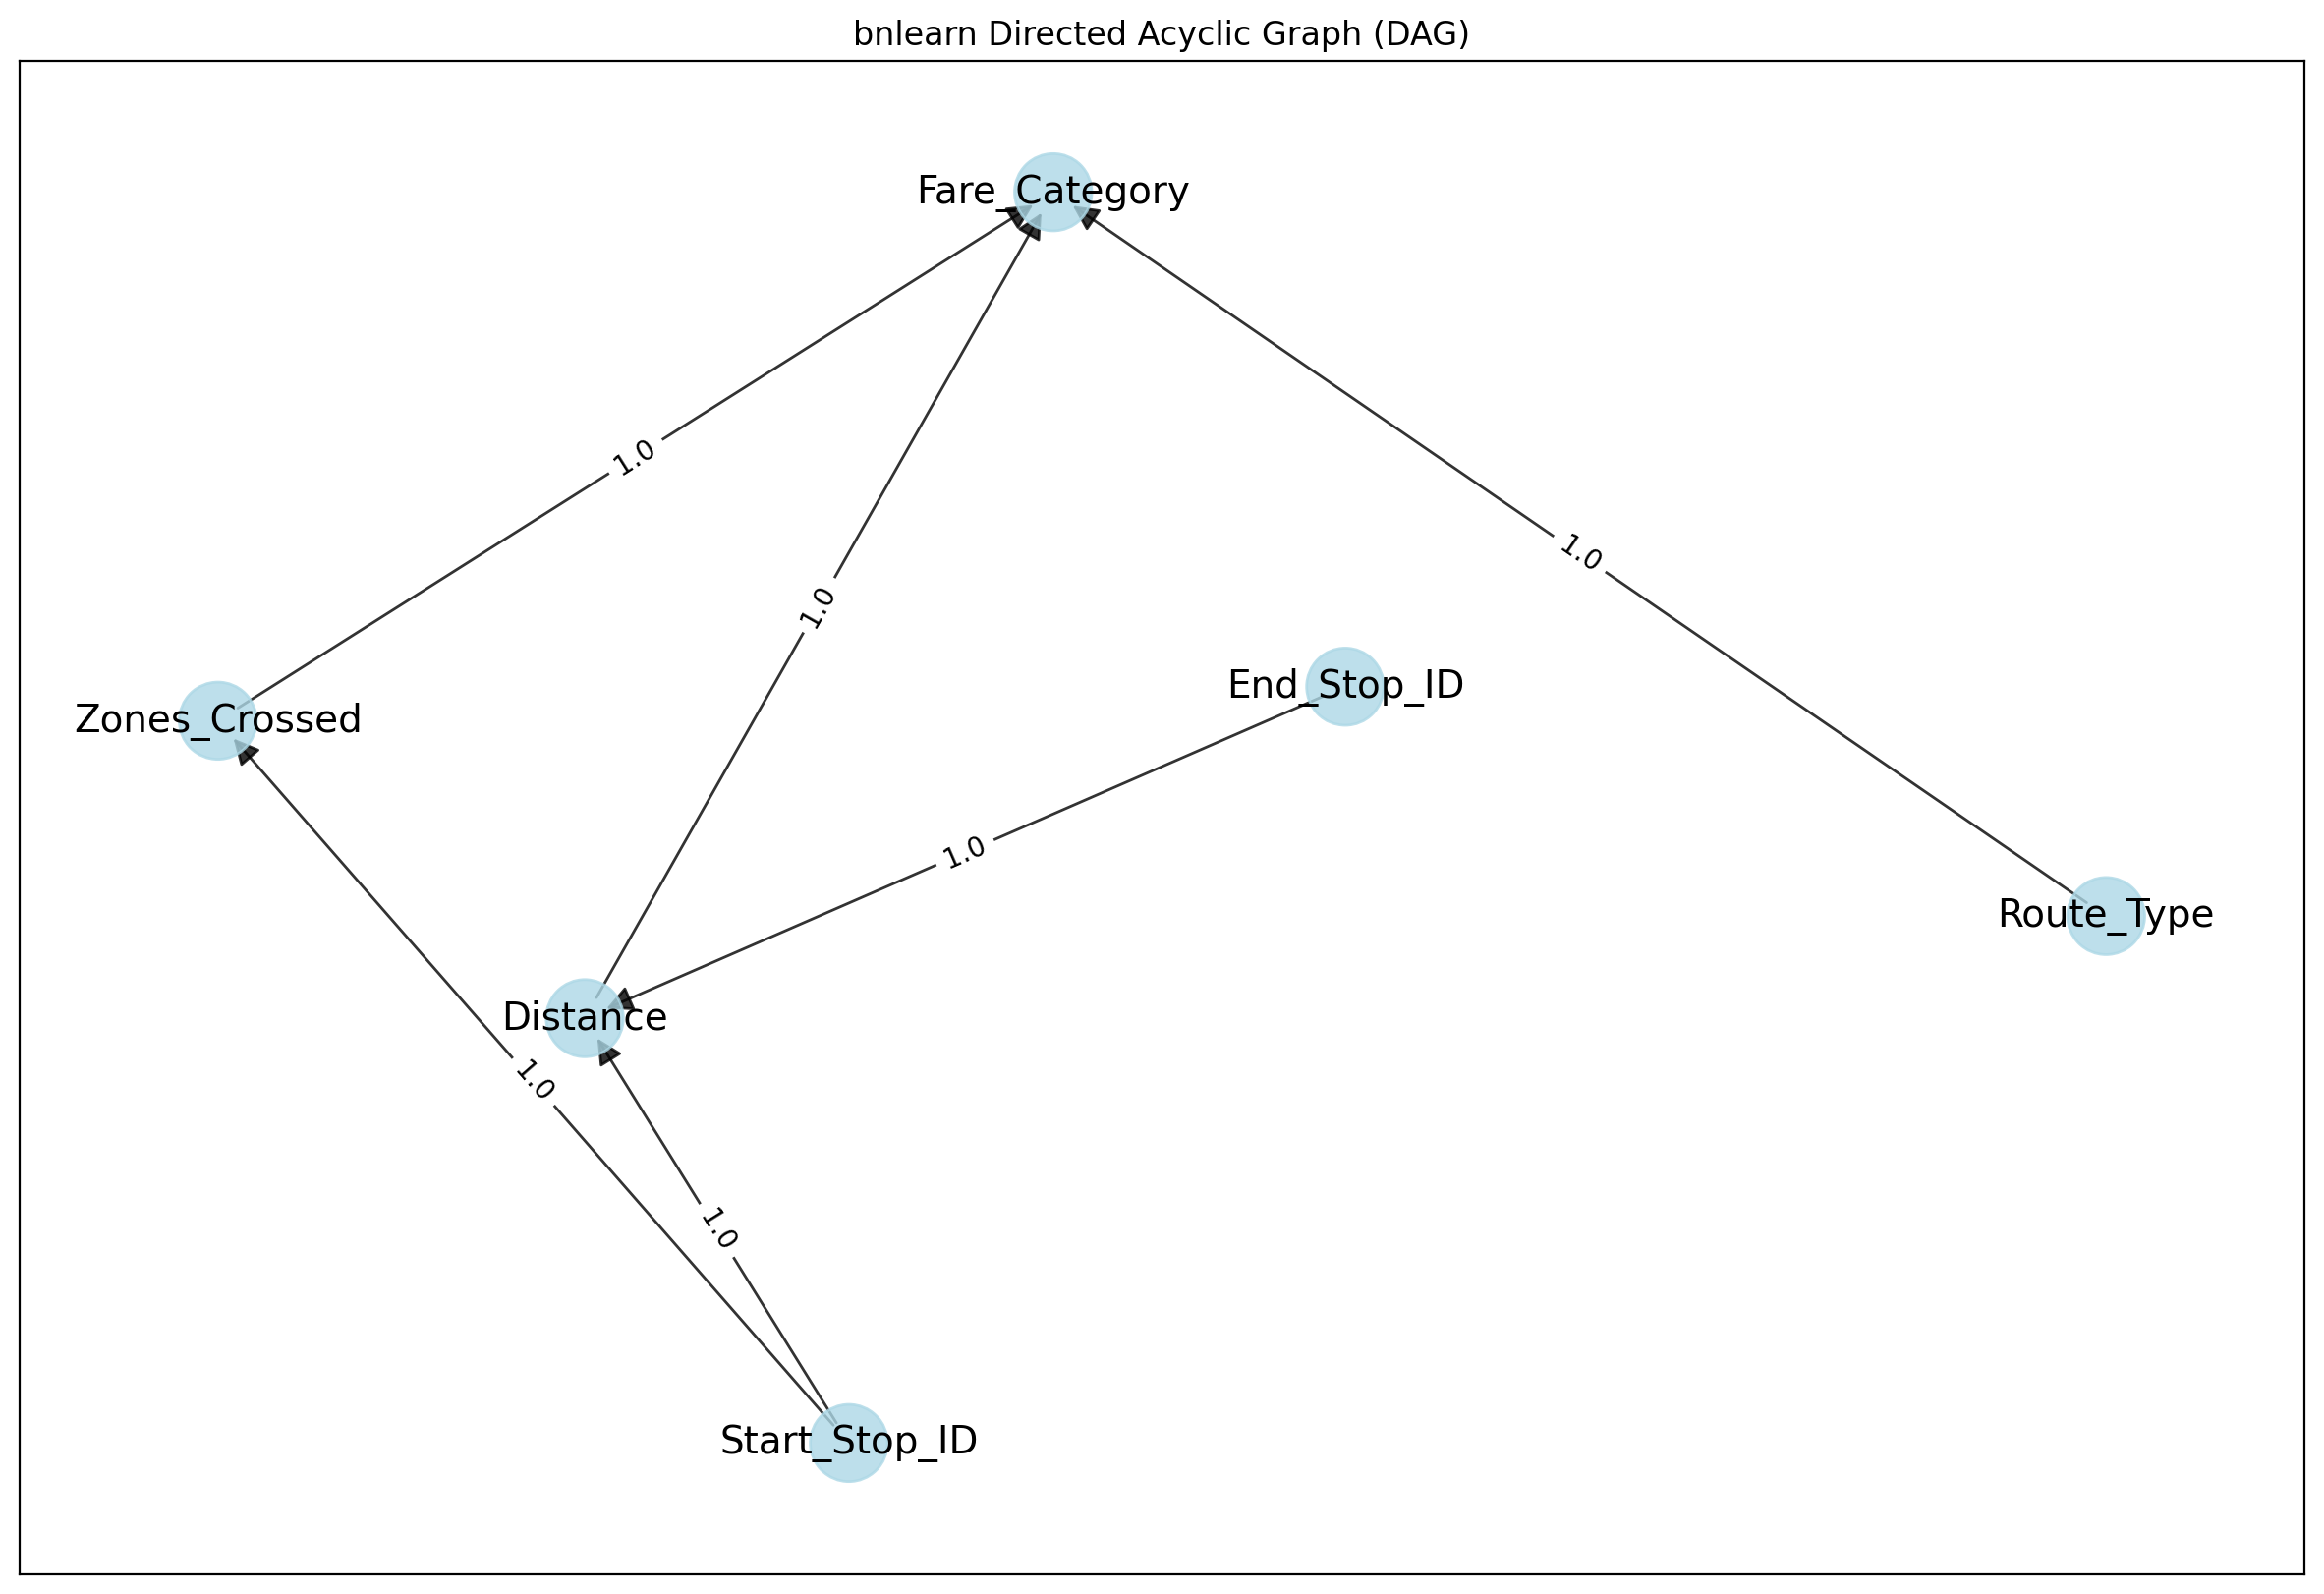

Model successfully saved to pruned_model.pkl.
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+----------+
|    | Fare_Category   |        p |
+====+=================+==========+
|  0 | High            | 0.877788 |
+----+-----------------+----------+
|  1 | Low             | 0.061106 |
+----+-----------------+----------+
|  2 | Medium          | 0.061106 |
+----+-----------------+----------+
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+-----------+
|    | Fare_Category   |         p |
+====+=================+===========+
|  0 | High            | 0.0116795 |
+----+-----------------+-----------+
|  1 | Low             | 0.0116795 |
+----+-----------------+-----------+
|  2 | Medium          | 0.976641  |
+----+-----------------+-----------+
[bnlearn] >Variable Elimi

In [7]:
############
## Driver ##
############

def main():
    # Load data
    train_df, val_df = load_data()

    # # Create and save base model
    # base_model = make_network(train_df.copy())
    # save_model("base_model.pkl", base_model)

    # Create and save pruned model
    pruned_network = make_pruned_network(train_df.copy())
    save_model("pruned_model.pkl", pruned_network)

    # # Create and save optimized model
    # optimized_network = make_optimized_network(train_df.copy())
    # save_model("optimized_model.pkl", optimized_network)

    # Evaluate all models on the validation set
    # evaluate("base_model", val_df)
    evaluate("pruned_model", val_df)
    # evaluate("optimized_model", val_df)

    print("[+] Done")

if __name__ == "__main__":
    main()

Data loaded successfully.
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >bayes DAG created.
[bnlearn] >Removing columns from dataframe to make consistent with DAG [['Route_Type']]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Distance:
+------------------+-----+-----------------------+
| Fare_Category    | ... | Fare_Category(Medium) |
+------------------+-----+-----------------------+
| Distance(long)   | ... | 0.06530825496342738   |
+------------------+-----+-----------------------+
| Distance(medium) | ... | 0.8693834900731453    |
+------------------+-----+-----------------------+
| Distance(short)  | ... | 0.06530825496342738   |
+------------------+-----+-----------------------+
[bnlearn] >CPD of Start_Stop_ID:
+----------------------+-----+-----------------------+
| Distance             | ... | Distance(short)       |
+----

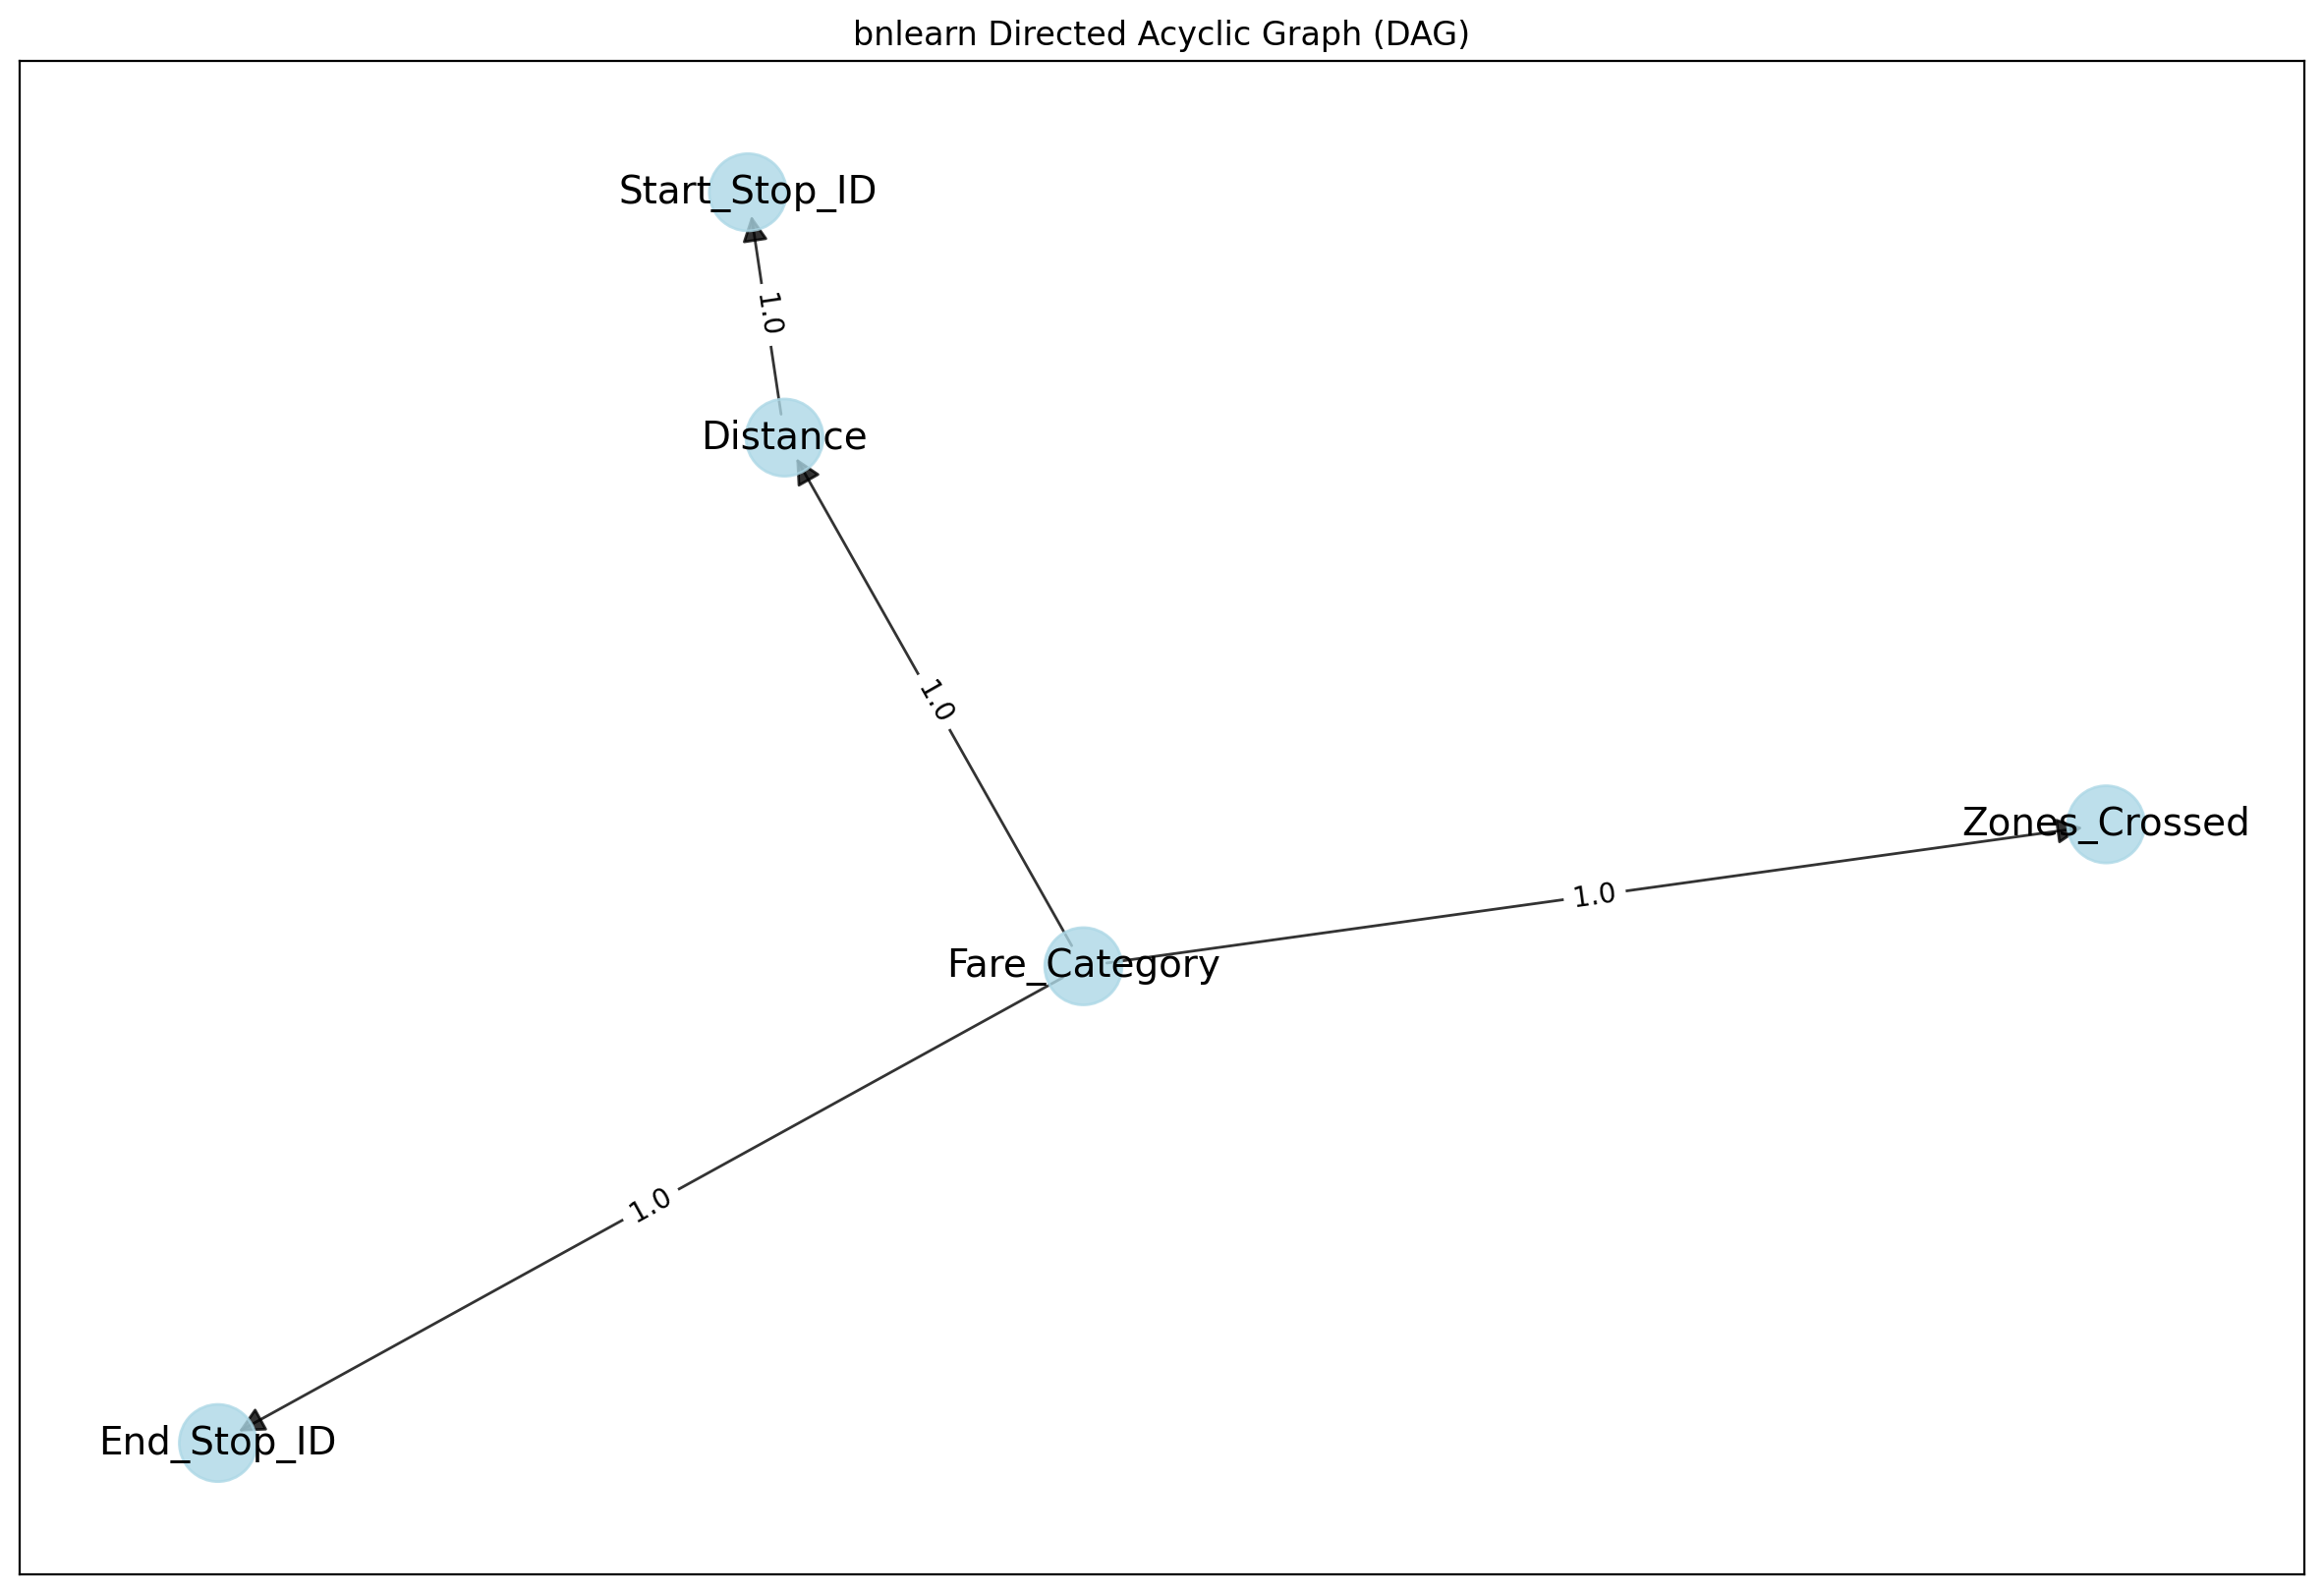

Optimized network created successfully.
Model successfully saved to optimized_model.pkl.
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+------------+
|    | Fare_Category   |          p |
+====+=================+============+
|  0 | High            | 0.993031   |
+----+-----------------+------------+
|  1 | Low             | 0.00469922 |
+----+-----------------+------------+
|  2 | Medium          | 0.00226948 |
+----+-----------------+------------+
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+-------------+
|    | Fare_Category   |           p |
+====+=================+=============+
|  0 | High            | 0.000197447 |
+----+-----------------+-------------+
|  1 | Low             | 0.000226499 |
+----+-----------------+-------------+
|  2 | Medium          |

In [8]:
############
## Driver ##
############

def main():
    # Load data
    train_df, val_df = load_data()

    # # Create and save base model
    # base_model = make_network(train_df.copy())
    # save_model("base_model.pkl", base_model)

    # # Create and save pruned model
    # pruned_network = make_pruned_network(train_df.copy())
    # save_model("pruned_model.pkl", pruned_network)

    # Create and save optimized model
    optimized_network = make_optimized_network(train_df.copy())
    save_model("optimized_model.pkl", optimized_network)

    # Evaluate all models on the validation set
    # evaluate("base_model", val_df)
    # evaluate("pruned_model", val_df)
    evaluate("optimized_model", val_df)

    print("[+] Done")

if __name__ == "__main__":
    main()